In [910]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from sklearn.metrics import explained_variance_score, \
    mean_absolute_error, \
    median_absolute_error
from sklearn.model_selection import train_test_split

In [911]:
np.random.seed(4747)

## Let's run through a basic analysis of one proxy Organism

#### Arctic Bay, Arctic: Coralline Algae (1967-2008)

In [912]:
raw_paleo_data = pd.read_csv("d18O_raw/ab_d18O_raw.csv")
raw_paleo_data.head()

,year,d18O
0,2008,-0.048160
1,2007,-0.045444
2,2006,-0.070624
3,2005,-0.095804
4,2004,0.027000


In [913]:
temp_data = pd.read_csv("temp_raw/ab_SODA_1x1_raw.csv")
temp_data.head(10)

,Unnamed: 0,time,lat,lon,depth,temp,salt
0,1,1967-01-15T00:00:00Z,72.75,273.75,5.01,-1.280347,31.575184
1,2,1967-01-15T00:00:00Z,72.75,274.25,5.01,-1.280931,31.576525
2,3,1967-01-15T00:00:00Z,73.25,273.75,5.01,-1.298791,31.579832
3,4,1967-01-15T00:00:00Z,73.25,274.25,5.01,-1.324163,31.503399
4,5,1967-01-15T00:00:00Z,73.75,273.75,5.01,-1.425924,30.357185
5,6,1967-01-15T00:00:00Z,73.75,274.25,5.01,-1.409098,30.414881
6,7,1967-02-15T00:00:00Z,72.75,273.75,5.01,-1.279240,31.829067
7,8,1967-02-15T00:00:00Z,72.75,274.25,5.01,-1.281839,31.826092
8,9,1967-02-15T00:00:00Z,73.25,273.75,5.01,-1.320389,31.776814
9,10,1967-02-15T00:00:00Z,73.25,274.25,5.01,-1.360575,31.597593


Let's make sure this temperature is averaged across the grid such that each month only has one temperature and one salinity value across the multiple lat/long pairs. 

In [914]:
monthly_temp_data = temp_data.groupby('time')

print(monthly_temp_data['temp'].agg(np.mean))

time
1967-01-15T00:00:00Z   -1.336542
1967-02-15T00:00:00Z   -1.343062
1967-03-15T00:00:00Z   -1.377000
1967-04-15T00:00:00Z   -1.455148
1967-05-15T00:00:00Z   -1.514044
                          ...   
2008-08-15T00:00:00Z   -0.197338
2008-09-15T00:00:00Z   -0.944179
2008-10-15T00:00:00Z   -1.022546
2008-11-15T00:00:00Z   -1.116120
2008-12-15T00:00:00Z   -1.164364
Name: temp, Length: 504, dtype: float64


Let's average these temperatures across years, across the grids. 

In [915]:
temp_data['year'] = temp_data['time'].apply(lambda x: x[0:4])
temp_data

,Unnamed: 0,time,lat,lon,depth,temp,salt,year
0,1,1967-01-15T00:00:00Z,72.75,273.75,5.01,-1.280347,31.575184,1967
1,2,1967-01-15T00:00:00Z,72.75,274.25,5.01,-1.280931,31.576525,1967
2,3,1967-01-15T00:00:00Z,73.25,273.75,5.01,-1.298791,31.579832,1967
3,4,1967-01-15T00:00:00Z,73.25,274.25,5.01,-1.324163,31.503399,1967
4,5,1967-01-15T00:00:00Z,73.75,273.75,5.01,-1.425924,30.357185,1967
...,...,...,...,...,...,...,...,...
3019,3020,2008-12-15T00:00:00Z,72.75,274.25,5.01,-1.109940,31.780386,2008
3020,3021,2008-12-15T00:00:00Z,73.25,273.75,5.01,-1.116151,31.646585,2008
3021,3022,2008-12-15T00:00:00Z,73.25,274.25,5.01,-1.128340,31.521568,2008
3022,3023,2008-12-15T00:00:00Z,73.75,273.75,5.01,-1.263921,30.873104,2008


Voila, now we have the average Sea Surface Temp for that lat/long grid on an annual basis:

In [916]:
actual_annual_temp = temp_data.groupby('year')['temp'].agg(np.mean).to_frame().reset_index()
# annual_temp['lat'] = 73.25
# annual_temp['long'] = 274.75

actual_annual_temp.head()

,year,temp
0,1967,-1.301917
1,1968,-0.175512
2,1969,-0.575391
3,1970,-1.314653
4,1971,-1.344812


Let's see how these two factors naturally correlate:

In [918]:
#pre-process for the merge

actual_annual_temp['year'] = actual_annual_temp['year'].apply(lambda x: int(x))

In [919]:
temp_and_algae = pd.merge(actual_annual_temp, paleo_data, on='year')
temp_and_algae.set_index('year').head()

,temp,d18O
year,,
1967,-1.301917,-0.132046
1968,-0.175512,-0.134891
1969,-0.575391,-0.137737
1970,-1.314653,-0.134845
1971,-1.344812,-0.131952


In [920]:
import matplotlib.pyplot as plt


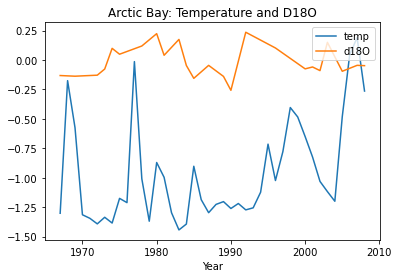

In [922]:
plt.plot(temp_and_algae['year'], temp_and_algae['temp'])
plt.plot(temp_and_algae['year'], temp_and_algae['d18O'])
plt.title('Arctic Bay: Temperature and D18O')
plt.xlabel('Year')
plt.legend(['temp', 'd18O'], loc='upper right')
plt.show()

We can see from the graph that there's some sort of relationships between the spikes in temp and d18O, but our correlation coefficient is rather underwhelming:

In [923]:
np.corrcoef(temp_and_algae['temp'], temp_and_algae['d18O'])

array([[ 1.        , -0.12974504],
       [-0.12974504,  1.        ]])

In [924]:
import statistics
statistics.variance(temp_and_algae['temp']), statistics.variance(temp_and_algae['d18O'])

(0.19341078570023343, 0.015289237992896332)

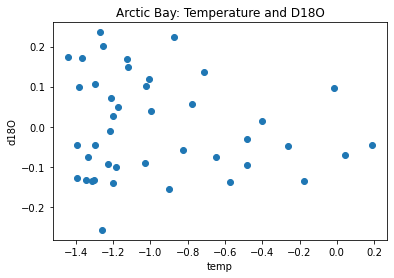

In [925]:
plt.scatter(temp_and_algae['temp'], temp_and_algae['d18O'])
plt.title('Arctic Bay: Temperature and D18O')
plt.xlabel('temp')
plt.ylabel('d18O')

# plt.legend(['temp', 'd18O'], loc='upper right')
plt.show()

Writing a function that can do this for any of the organisms on file:

In [926]:
def exploration(d18O_raw_filename, temp_raw_filename):
    raw_paleo_data = pd.read_csv("d18O_raw/" + d18O_raw_filename)
    temp_data = pd.read_csv("temp_raw/" + temp_raw_filename)
    
    temp_data['year'] = temp_data['time'].apply(lambda x: x[0:4])
    
    actual_annual_temp = temp_data.groupby('year')['temp'].agg(np.mean).to_frame().reset_index()
    actual_annual_temp['year'] = actual_annual_temp['year'].apply(lambda x: int(x))
    
    temp_and_algae = pd.merge(actual_annual_temp, paleo_data, on='year')
    temp_and_algae.set_index('year')
    
    print('pearson correlation:')
    print(np.corrcoef(temp_and_algae['temp'], temp_and_algae['d18O']))
    
    plt.plot(temp_and_algae['year'], temp_and_algae['temp'])
    plt.plot(temp_and_algae['year'], temp_and_algae['d18O'])
    plt.title(d18O_raw_filename.split("_")[0] +": Temperature and D18O")
    plt.xlabel('Year')
    plt.legend(['temp', 'd18O'], loc='upper right')
    plt.show()

pearson correlation:
[[1.         0.29219553]
 [0.29219553 1.        ]]


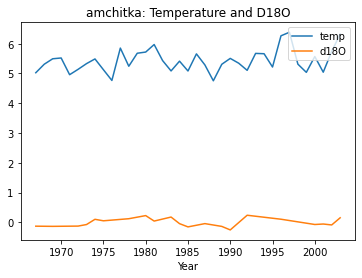

In [927]:
exploration('amchitka_d18O_raw.csv', 'amchitka_SODA_1x1_raw.csv')

pearson correlation:
[[1.         0.22937195]
 [0.22937195 1.        ]]


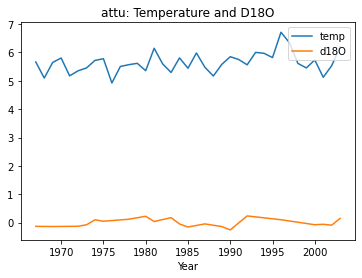

In [928]:
exploration('attu_d18O_raw.csv', 'attu_SODA_1x1_raw.csv')

pearson correlation:
[[ 1.         -0.15474578]
 [-0.15474578  1.        ]]


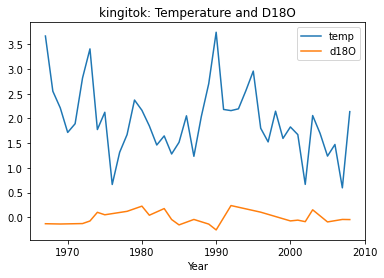

In [856]:
exploration('kingitok_d18O_raw.csv', 'Kingitok_SODA_1x1_raw.csv')

pearson correlation:
[[ 1.         -0.39210198]
 [-0.39210198  1.        ]]


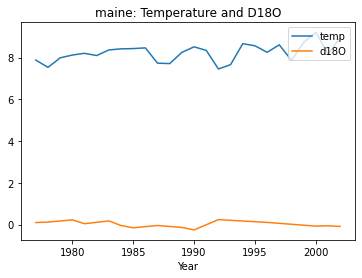

In [857]:
exploration('maine_d18O_raw.csv', 'maine_SODA_1x1_raw.csv')

pearson correlation:
[[ 1.         -0.12939033]
 [-0.12939033  1.        ]]


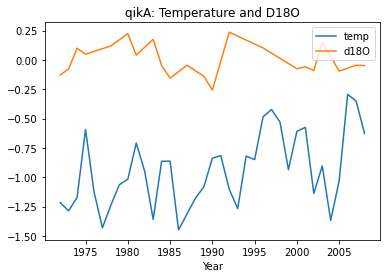

In [858]:
exploration('qikA_d18O_raw.csv', 'qikA_SODA_1x1_raw.csv')

pearson correlation:
[[ 1.         -0.10766705]
 [-0.10766705  1.        ]]


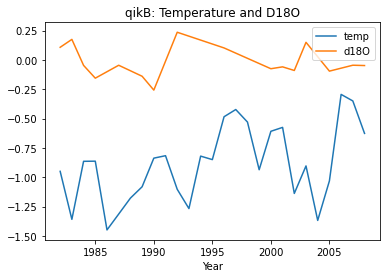

In [859]:
exploration('qikB_d18O_raw.csv', 'qikB_SODA_1x1_raw.csv')

In [929]:
algae_site_info = pd.read_csv("algae_site_info.csv")
algae_site_info

,site,lat,long,depth_meter
0,arctic_bay,73.25,274.75,5
1,amchitka,51.42,179.23,5
2,attu,52.78,173.17,5
3,kingitok,55.40,300.15,15
4,maine,44.13,291.75,10
5,qikA,67.56,295.98,5
6,qikB,67.56,295.98,5


By the way, here is where our sample locations are in the world. You can see that they're a bit crowded around the Northwest of the map below. 

In [930]:
import shapely
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

algae_site_info['long_formatted'] = algae_site_info['long'] - 360
algae_site_info

,site,lat,long,depth_meter,long_formatted
0,arctic_bay,73.25,274.75,5,-85.25
1,amchitka,51.42,179.23,5,-180.77
2,attu,52.78,173.17,5,-186.83
3,kingitok,55.40,300.15,15,-59.85
4,maine,44.13,291.75,10,-68.25
5,qikA,67.56,295.98,5,-64.02
6,qikB,67.56,295.98,5,-64.02


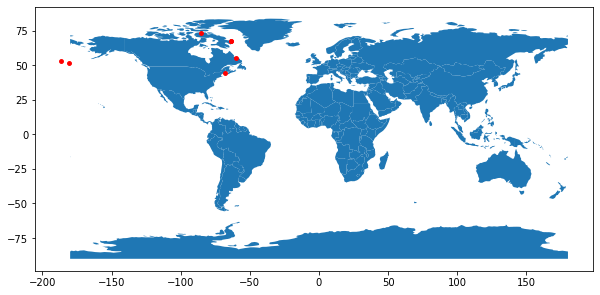

In [931]:
geometry = [Point(xy) for xy in zip(algae_site_info['long_formatted'], 
                                    algae_site_info['lat'])]

gdf = GeoDataFrame(algae_site_info, geometry=geometry)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

## Introducing, Aspects of Machine Learning

In [932]:
temp_and_algae['lat'] = 73.25
temp_and_algae['long'] = 274.75
temp_and_algae = temp_and_algae.reset_index()
temp_and_algae.head()

,index,year,temp,d18O,lat,long
0,0,1967,-1.301917,-0.132046,73.25,274.75
1,1,1968,-0.175512,-0.134891,73.25,274.75
2,2,1969,-0.575391,-0.137737,73.25,274.75
3,3,1970,-1.314653,-0.134845,73.25,274.75
4,4,1971,-1.344812,-0.131952,73.25,274.75


As a proof of concept, let's build a little 'neural network' with all of our algae datasets. We want to predict `temp`, given `year`, `d18O`, `lat`, and `long`.

First, let'sconfigure all the data into one big dataframe.

Then, let's scale everything between 1 and 0

In [864]:
paleo_df = ''
paleo_df

''

In [933]:
algae_files = [['ab_d18O_raw.csv', 73.25, 274.75, 5],
                ['amchitka_d18O_raw.csv', 51.42, 179.23, 5], 
                ['attu_d18O_raw.csv', 52.78, 173.17, 5],
                ['Kingitok_d18O_raw.csv', 55.4, 300.15, 15],
                #['maine_d18O_raw.csv',44.13,291.75,10],
                ['qikA_d18O_raw.csv', 67.56,295.98,5],
                ['qikB_d18O_raw.csv', 67.56,295.98,5]
               ]
                 
                 
temperature_files = [
    'ab_SODA_1x1_raw.csv', 
    'amchitka_SODA_1x1_raw.csv',
    'attu_SODA_1x1_raw.csv',
    'kingitok_SODA_1x1_raw.csv', 
    #'maine_SODA_1x1_raw.csv',
    'qikA_SODA_1x1_raw.csv', 
    'qikB_SODA_1x1_raw.csv']

In [934]:
paleo_df = ''
paleo_df = pd.DataFrame()

count = 0
for temperature_file in temperature_files:
    temp_data = pd.read_csv('temp_raw/' + temperature_file)
    print(temperature_file)
    # locate the year value
    temp_data['year'] = temp_data['time'].apply(lambda x: x[0:4])
    # group data annually
    actual_annual_temp = temp_data.groupby('year')['temp'].agg(np.mean).to_frame().reset_index()
    # convert year to an int type
    actual_annual_temp['year'] = actual_annual_temp['year'].apply(lambda x: int(x))
    
    algae_file = pd.read_csv('d18O_raw/' + algae_files[count][0])
    
    if algae_files[count][0] == "amchitka_d18O_raw.csv":
        algae_file = algae_file[['Year', 'AM-KR-80_d18O']]
        algae_file['d18O'] = algae_file['AM-KR-80_d18O']
        algae_file['year'] = algae_file['Year'].apply(lambda x: int(x))
        del algae_file['AM-KR-80_d18O']
        del algae_file['Year']
    
    elif algae_files[count][0] == "attu_d18O_raw.csv":
        algae_file = algae_file[['year', 'd18O']]
    else:
        algae_file['year'] = algae_file['year'].apply(lambda x: int(x))
    print(algae_files[count][0])
    
    
    temp_and_algae = pd.merge(actual_annual_temp, algae_file, on='year')
    #temp_and_algae = temp_and_algae.set_index('year').head()
    temp_and_algae['lat'] = algae_files[count][1]
    temp_and_algae['long'] = algae_files[count][2]
    temp_and_algae['depth'] = algae_files[count][3]
    temp_and_algae['location'] = temperature_file.split('_')[0]
    paleo_df = pd.concat([paleo_df, temp_and_algae], axis= 0)
    
    count += 1
    
paleo_df

ab_SODA_1x1_raw.csv
ab_d18O_raw.csv
amchitka_SODA_1x1_raw.csv
amchitka_d18O_raw.csv
attu_SODA_1x1_raw.csv
attu_d18O_raw.csv
kingitok_SODA_1x1_raw.csv
Kingitok_d18O_raw.csv
qikA_SODA_1x1_raw.csv
qikA_d18O_raw.csv
qikB_SODA_1x1_raw.csv
qikB_d18O_raw.csv


,year,temp,d18O,lat,long,depth,location
0,1967,-1.301917,-0.132046,73.25,274.75,5,ab
1,1968,-0.175512,-0.134891,73.25,274.75,5,ab
2,1969,-0.575391,-0.137737,73.25,274.75,5,ab
3,1970,-1.314653,-0.134845,73.25,274.75,5,ab
4,1971,-1.344812,-0.131952,73.25,274.75,5,ab
...,...,...,...,...,...,...,...
22,2004,-1.368374,-1.801891,67.56,295.98,5,qikB
23,2005,-1.031412,-2.045915,67.56,295.98,5,qikB
24,2006,-0.294162,-2.200304,67.56,295.98,5,qikB
25,2007,-0.349986,-2.143647,67.56,295.98,5,qikB


In [935]:
dataset = paleo_df.values
dataset

array([[1967, -1.3019167168272867, -0.13204552, ..., 274.75, 5, 'ab'],
       [1968, -0.1755116544922609, -0.13489132, ..., 274.75, 5, 'ab'],
       [1969, -0.5753912617866366, -0.13773713, ..., 274.75, 5, 'ab'],
       ...,
       [2006, -0.294161577132486, -2.200303795, ..., 295.98, 5, 'qikB'],
       [2007, -0.34998577832898486, -2.1436467009999998, ..., 295.98, 5,
        'qikB'],
       [2008, -0.6265848786348389, -2.214012989, ..., 295.98, 5, 'qikB']],
      dtype=object)

In [936]:
# dataset[row indices, column indices]
X =  dataset[:,(0,2,3,4,5)] # input
Y = dataset[:, 2] # output

In [937]:
X

array([[1967, -0.13204552, 73.25, 274.75, 5],
       [1968, -0.13489132, 73.25, 274.75, 5],
       [1969, -0.13773713, 73.25, 274.75, 5],
       ...,
       [2006, -2.200303795, 67.56, 295.98, 5],
       [2007, -2.1436467009999998, 67.56, 295.98, 5],
       [2008, -2.214012989, 67.56, 295.98, 5]], dtype=object)

In [938]:
from sklearn import preprocessing

In [939]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)
X_scale

array([[0.18      , 0.88054431, 1.        , 0.7999685 , 0.        ],
       [0.2       , 0.87961982, 1.        , 0.7999685 , 0.        ],
       [0.22      , 0.87869532, 1.        , 0.7999685 , 0.        ],
       ...,
       [0.96      , 0.20864845, 0.73934952, 0.96716018, 0.        ],
       [0.98      , 0.22705412, 0.73934952, 0.96716018, 0.        ],
       [1.        , 0.20419487, 0.73934952, 0.96716018, 0.        ]])

In [872]:
from sklearn.model_selection import train_test_split

In [940]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(
    X_scale, Y, test_size=0.2)

In [941]:
X_train.shape

(186, 5)

In [942]:
X_val_and_test.shape

(47, 5)

In [1035]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.advanced_activations import LeakyReLU

In [1038]:
model = Sequential([
    Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.2), input_shape=(5,), kernel_initializer='normal'),
    #kernel_initializer='normal'
#    Dense(32, activation='relu', input_shape=(5,)),
#      Dense(32, activation='relu'),
#      Dense(16, activation='relu'),
#      Dense(16, activation='relu'),
#      Dense(16, activation='relu'),
    Dense(1, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
])

In [1039]:
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[
        'MeanSquaredError',
    ]
)

In [879]:
# from sklearn.metrics import r2_score

# model.compile(optimizer='sgd',
#               loss='binary_crossentropy',
#               metrics=['r2_score'])

In [993]:
X_train = np.asarray(X_train).astype(np.float32)
Y_train = np.asarray(Y_train).astype(np.float32)
X_val_and_test = np.asarray(X_val_and_test).astype(np.float32)
Y_val_and_test = np.asarray(Y_val_and_test).astype(np.float32)

In [994]:
Y_val_and_test

array([-1.75      , -2.349375  , -1.97      , -2.076875  ,  0.13535108,
       -1.7553    , -2.7866337 , -2.1216667 , -2.3165345 , -2.432475  ,
       -1.9299636 ,  0.11885414, -1.8371    , -1.1839    , -2.05      ,
       -2.8158424 , -2.06      , -1.9951487 , -2.0651486 , -2.0698245 ,
       -2.1442575 , -2.023125  , -1.3734    , -2.2276778 , -1.9110888 ,
        0.22368714, -1.6056666 , -0.13951118, -1.4932    , -2.6134653 ,
        0.16879007, -2.5616834 , -0.13195188, -1.71      ,  0.09555791,
       -2.0998018 , -1.2431    , -2.4389002 , -1.94      , -2.3197029 ,
       -0.04544379, -1.52      , -1.91      , -2.2349505 , -1.5512    ,
       -0.1008198 , -2.2348642 ], dtype=float32)

In [1049]:
hist = model.fit(X_train, Y_train,
          batch_size=16, epochs=64,
          validation_data=(X_val_and_test, Y_val_and_test))

Epoch 1/64
12/12 [==============================] - 0s 9ms/step - loss: 0.6541 - mean_squared_error: 0.6541 - val_loss: 0.6627 - val_mean_squared_error: 0.6627
Epoch 2/64
12/12 [==============================] - 0s 3ms/step - loss: 0.6402 - mean_squared_error: 0.6402 - val_loss: 0.6462 - val_mean_squared_error: 0.6462
Epoch 3/64
12/12 [==============================] - 0s 3ms/step - loss: 0.6254 - mean_squared_error: 0.6254 - val_loss: 0.6303 - val_mean_squared_error: 0.6303
Epoch 4/64
12/12 [==============================] - 0s 3ms/step - loss: 0.6110 - mean_squared_error: 0.6110 - val_loss: 0.6170 - val_mean_squared_error: 0.6170
Epoch 5/64
12/12 [==============================] - 0s 3ms/step - loss: 0.5982 - mean_squared_error: 0.5982 - val_loss: 0.6013 - val_mean_squared_error: 0.6013
Epoch 6/64
12/12 [==============================] - 0s 3ms/step - loss: 0.5843 - mean_squared_error: 0.5843 - val_loss: 0.5867 - val_mean_squared_error: 0.5867
Epoch 7/64
12/12 [======================

Epoch 52/64
12/12 [==============================] - 0s 3ms/step - loss: 0.1190 - mean_squared_error: 0.1190 - val_loss: 0.1228 - val_mean_squared_error: 0.1228
Epoch 53/64
12/12 [==============================] - 0s 2ms/step - loss: 0.1147 - mean_squared_error: 0.1147 - val_loss: 0.1220 - val_mean_squared_error: 0.1220
Epoch 54/64
12/12 [==============================] - 0s 2ms/step - loss: 0.1111 - mean_squared_error: 0.1111 - val_loss: 0.1179 - val_mean_squared_error: 0.1179
Epoch 55/64
12/12 [==============================] - 0s 2ms/step - loss: 0.1074 - mean_squared_error: 0.1074 - val_loss: 0.1144 - val_mean_squared_error: 0.1144
Epoch 56/64
12/12 [==============================] - 0s 2ms/step - loss: 0.1041 - mean_squared_error: 0.1041 - val_loss: 0.1119 - val_mean_squared_error: 0.1119
Epoch 57/64
12/12 [==============================] - 0s 3ms/step - loss: 0.1014 - mean_squared_error: 0.1014 - val_loss: 0.1097 - val_mean_squared_error: 0.1097
Epoch 58/64
12/12 [===============

In [1050]:
model.evaluate(X_val_and_test, Y_val_and_test)[1]

2/2 [==============================] - 0s 5ms/step - loss: 0.0894 - mean_squared_error: 0.0894


0.08941114693880081

In [884]:
import matplotlib.pyplot as plt

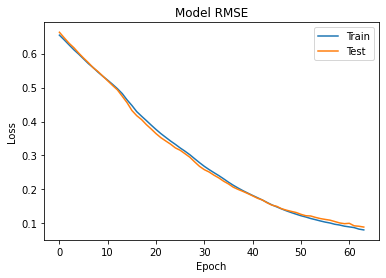

In [1076]:
plt.plot(hist.history['mean_squared_error'])
plt.plot(hist.history['val_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Let's try to visualize this on a time series plot

In [887]:
# X_val_and_test

In [889]:
# Y_val_and_test

In [1052]:
actual = pd.DataFrame(Y_val_and_test, columns=["actual"])
actual.head()

,actual
0,-1.750000
1,-2.349375
2,-1.970000
3,-2.076875
4,0.135351


In [1053]:
predicted = pd.DataFrame(model.predict(X_val_and_test), columns=["pred"])
predicted.head()

,pred
0,-1.879443
1,-2.151942
2,-1.793195
3,-2.055185
4,-0.310067


In [1058]:
actual_v_pred = actual.join(predicted, how = "inner")
#actual_v_pred['pred_altered'] = actual_v_pred['pred'].apply(lambda x: (((x-1)/2)**2)*5)
actual_v_pred.head()

,actual,pred
0,-1.750000,-1.879443
1,-2.349375,-2.151942
2,-1.970000,-1.793195
3,-2.076875,-2.055185
4,0.135351,-0.310067


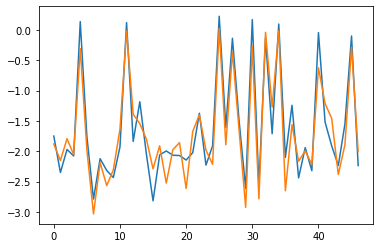

In [1055]:
plt.plot(actual_v_pred)

In [1056]:
import numpy as np
np.corrcoef(actual_v_pred['actual'], actual_v_pred['pred'])

array([[1.        , 0.94245346],
       [0.94245346, 1.        ]])

In [1057]:
from scipy.stats import pearsonr

pearsonr(actual_v_pred['actual'], actual_v_pred['pred'])

(0.9424534647060682, 4.850945223102567e-23)

This says that the two variables have a correlation of 0.924 and a p-value of basically 0. 

Let's try a regular linear regression model:

In [1048]:
from sklearn.linear_model import LinearRegression

In [1015]:
model = LinearRegression()
model.fit(X_train, Y_train)
preds_linear = pd.DataFrame(model.predict(X_val_and_test), columns=["pred"])
#print("Loss: " + str(loss(rounded_preds, test_labels)))

In [1059]:
actual_v_pred_linear = actual.join(preds_linear, how = "inner")
actual_v_pred_linear['diff'] = actual_v_pred_linear['actual'] - actual_v_pred_linear['pred']
actual_v_pred_linear.head()

,actual,pred,diff
0,-1.750000,-1.750001,5.960464e-07
1,-2.349375,-2.349375,2.384186e-07
2,-1.970000,-1.970001,4.768372e-07
3,-2.076875,-2.076875,4.768372e-07
4,0.135351,0.135351,1.341105e-07


In [1017]:
from sklearn.metrics import mean_squared_error
model.score(X_train, Y_train), mean_squared_error(Y_val_and_test, preds_linear)

(0.9999999999996956, 2.0323813e-13)

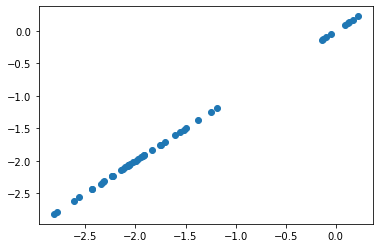

In [1018]:
plt.scatter(actual_v_pred_linear['actual'],actual_v_pred_linear['pred'] )

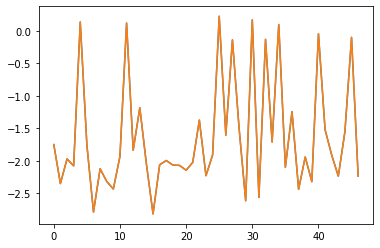

In [1019]:
plt.plot(actual_v_pred_linear['actual'])
plt.plot(actual_v_pred_linear['pred'])

WOw, the predicted are so similar to the actual that you cannot discern between the two.

In [1020]:
print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)

Intercept: 
 -2.8425746
Coefficients: 
 [-1.4965178e-07  3.0782418e+00  6.9222273e-07 -3.5156879e-07
  3.6100064e-07]


Perhaps as expected, the model was able to discern that the d18O was the most important factor in determining the predicted temperature. This is seen by the second coefficient in the model (relating to d18O) being the largest number. It appears as tho the other coefficients (relating to year, lat, long, and depth) are extraordinarily tiny comparatively.

In [1077]:
paleo_df

,year,temp,d18O,lat,long,depth,location
0,1967,-1.301917,-0.132046,73.25,274.75,5,ab
1,1968,-0.175512,-0.134891,73.25,274.75,5,ab
2,1969,-0.575391,-0.137737,73.25,274.75,5,ab
3,1970,-1.314653,-0.134845,73.25,274.75,5,ab
4,1971,-1.344812,-0.131952,73.25,274.75,5,ab
...,...,...,...,...,...,...,...
22,2004,-1.368374,-1.801891,67.56,295.98,5,qikB
23,2005,-1.031412,-2.045915,67.56,295.98,5,qikB
24,2006,-0.294162,-2.200304,67.56,295.98,5,qikB
25,2007,-0.349986,-2.143647,67.56,295.98,5,qikB


## Sequential Neural Network

Okay.. so linear regression seemed to do the trick for these organisms really damn well. Let's see if we can recreate this with a Sequential Neural Network (aka: a sequence of linear combinations as a result of matrix operations). We will be using the ReLU activation function ( a linear function )

In [1066]:
network = Sequential()
network.add(Dense(8, input_shape=(5,), activation='LeakyReLU'))
network.add(Dense(6, activation='LeakyReLU'))
network.add(Dense(6, activation='LeakyReLU'))
network.add(Dense(4, activation='LeakyReLU'))
network.add(Dense(1, activation='LeakyReLU'))

network.compile('adam', loss='mse', metrics=['mse'])
network.fit(X_train, Y_train, epochs=1000)

Epoch 1/1000
6/6 [==============================] - 1s 2ms/step - loss: 2.6353 - mse: 2.6353
Epoch 2/1000
6/6 [==============================] - 0s 2ms/step - loss: 2.4555 - mse: 2.4555
Epoch 3/1000
6/6 [==============================] - 0s 2ms/step - loss: 2.2727 - mse: 2.2727
Epoch 4/1000
6/6 [==============================] - 0s 1ms/step - loss: 2.0853 - mse: 2.0853
Epoch 5/1000
6/6 [==============================] - 0s 2ms/step - loss: 1.8906 - mse: 1.8906
Epoch 6/1000
6/6 [==============================] - 0s 1ms/step - loss: 1.7009 - mse: 1.7009
Epoch 7/1000
6/6 [==============================] - 0s 1ms/step - loss: 1.5069 - mse: 1.5069
Epoch 8/1000
6/6 [==============================] - 0s 2ms/step - loss: 1.3188 - mse: 1.3188
Epoch 9/1000
6/6 [==============================] - 0s 2ms/step - loss: 1.1505 - mse: 1.1505
Epoch 10/1000
6/6 [==============================] - 0s 2ms/step - loss: 1.0045 - mse: 1.0045
Epoch 11/1000
6/6 [==============================] - 0s 2ms/step - lo

6/6 [==============================] - 0s 1ms/step - loss: 0.0419 - mse: 0.0419
Epoch 89/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0410 - mse: 0.0410
Epoch 90/1000
6/6 [==============================] - 0s 2ms/step - loss: 0.0400 - mse: 0.0400
Epoch 91/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0392 - mse: 0.0392
Epoch 92/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0384 - mse: 0.0384
Epoch 93/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0375 - mse: 0.0375
Epoch 94/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0367 - mse: 0.0367
Epoch 95/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0359 - mse: 0.0359
Epoch 96/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0351 - mse: 0.0351
Epoch 97/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0344 - mse: 0.0344
Epoch 98/1000
6/6 [==============================] - 0s 1ms/step - loss: 0

6/6 [==============================] - 0s 1ms/step - loss: 0.0108 - mse: 0.0108
Epoch 175/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0107 - mse: 0.0107
Epoch 176/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0106 - mse: 0.0106
Epoch 177/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0105 - mse: 0.0105
Epoch 178/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0104 - mse: 0.0104
Epoch 179/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0102 - mse: 0.0102
Epoch 180/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0102 - mse: 0.0102
Epoch 181/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0100 - mse: 0.0100
Epoch 182/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0099 - mse: 0.0099
Epoch 183/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0098 - mse: 0.0098
Epoch 184/1000
6/6 [==============================] - 0s 1ms/step

6/6 [==============================] - 0s 877us/step - loss: 0.0049 - mse: 0.0049
Epoch 261/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0048 - mse: 0.0048
Epoch 262/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0048 - mse: 0.0048
Epoch 263/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0048 - mse: 0.0048
Epoch 264/1000
6/6 [==============================] - 0s 952us/step - loss: 0.0047 - mse: 0.0047
Epoch 265/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0047 - mse: 0.0047
Epoch 266/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0047 - mse: 0.0047
Epoch 267/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0047 - mse: 0.0047
Epoch 268/1000
6/6 [==============================] - 0s 989us/step - loss: 0.0046 - mse: 0.0046
Epoch 269/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0046 - mse: 0.0046
Epoch 270/1000
6/6 [==============================] - 0s 1m

6/6 [==============================] - 0s 1ms/step - loss: 0.0032 - mse: 0.0032
Epoch 346/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0032 - mse: 0.0032
Epoch 347/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0032 - mse: 0.0032
Epoch 348/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0032 - mse: 0.0032
Epoch 349/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0031 - mse: 0.0031
Epoch 350/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0031 - mse: 0.0031
Epoch 351/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0032 - mse: 0.0032
Epoch 352/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0031 - mse: 0.0031
Epoch 353/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0031 - mse: 0.0031
Epoch 354/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0031 - mse: 0.0031
Epoch 355/1000
6/6 [==============================] - 0s 1ms/step

6/6 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.0019
Epoch 432/1000
6/6 [==============================] - 0s 970us/step - loss: 0.0019 - mse: 0.0019
Epoch 433/1000
6/6 [==============================] - 0s 987us/step - loss: 0.0019 - mse: 0.0019
Epoch 434/1000
6/6 [==============================] - 0s 964us/step - loss: 0.0019 - mse: 0.0019
Epoch 435/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.0019
Epoch 436/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.0019
Epoch 437/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.0019
Epoch 438/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.0019
Epoch 439/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0019 - mse: 0.0019
Epoch 440/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.0018
Epoch 441/1000
6/6 [==============================] - 0s 1m

6/6 [==============================] - 0s 969us/step - loss: 0.0014 - mse: 0.0014
Epoch 518/1000
6/6 [==============================] - 0s 986us/step - loss: 0.0014 - mse: 0.0014
Epoch 519/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0015 - mse: 0.0015
Epoch 520/1000
6/6 [==============================] - 0s 942us/step - loss: 0.0014 - mse: 0.0014
Epoch 521/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014
Epoch 522/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014
Epoch 523/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014
Epoch 524/1000
6/6 [==============================] - 0s 980us/step - loss: 0.0014 - mse: 0.0014
Epoch 525/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014    
Epoch 526/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014    
Epoch 527/1000
6/6 [=============================

6/6 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 0.0012
Epoch 603/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 0.0012    
Epoch 604/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 0.0012
Epoch 605/1000
6/6 [==============================] - 0s 962us/step - loss: 0.0012 - mse: 0.0012
Epoch 606/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 0.0012
Epoch 607/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 0.0012
Epoch 608/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 0.0012
Epoch 609/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 0.0012
Epoch 610/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 0.0012    
Epoch 611/1000
6/6 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 0.0012    
Epoch 612/1000
6/6 [==============================]

6/6 [==============================] - 0s 1ms/step - loss: 0.0010 - mse: 0.0010
Epoch 687/1000
6/6 [==============================] - 0s 1ms/step - loss: 9.9827e-04 - mse: 9.9827e-04
Epoch 688/1000
6/6 [==============================] - 0s 1ms/step - loss: 9.9667e-04 - mse: 9.9667e-04
Epoch 689/1000
6/6 [==============================] - 0s 1ms/step - loss: 9.8571e-04 - mse: 9.8571e-04
Epoch 690/1000
6/6 [==============================] - 0s 1ms/step - loss: 9.9213e-04 - mse: 9.9213e-04
Epoch 691/1000
6/6 [==============================] - 0s 1ms/step - loss: 9.8514e-04 - mse: 9.8514e-04
Epoch 692/1000
6/6 [==============================] - 0s 1ms/step - loss: 9.8716e-04 - mse: 9.8716e-04
Epoch 693/1000
6/6 [==============================] - 0s 1ms/step - loss: 9.7873e-04 - mse: 9.7873e-04
Epoch 694/1000
6/6 [==============================] - 0s 1ms/step - loss: 9.8008e-04 - mse: 9.8008e-04
Epoch 695/1000
6/6 [==============================] - 0s 1ms/step - loss: 9.8011e-04 - mse: 9.80

6/6 [==============================] - 0s 1ms/step - loss: 8.3452e-04 - mse: 8.3452e-04
Epoch 766/1000
6/6 [==============================] - 0s 1ms/step - loss: 8.3123e-04 - mse: 8.3123e-04
Epoch 767/1000
6/6 [==============================] - 0s 936us/step - loss: 8.2972e-04 - mse: 8.2972e-04
Epoch 768/1000
6/6 [==============================] - 0s 1ms/step - loss: 8.2427e-04 - mse: 8.2427e-04
Epoch 769/1000
6/6 [==============================] - 0s 943us/step - loss: 8.2808e-04 - mse: 8.2808e-04
Epoch 770/1000
6/6 [==============================] - 0s 1ms/step - loss: 8.1212e-04 - mse: 8.1212e-04
Epoch 771/1000
6/6 [==============================] - 0s 1ms/step - loss: 8.1713e-04 - mse: 8.1713e-04
Epoch 772/1000
6/6 [==============================] - 0s 1ms/step - loss: 8.1619e-04 - mse: 8.1619e-04
Epoch 773/1000
6/6 [==============================] - 0s 1ms/step - loss: 8.4322e-04 - mse: 8.4322e-04
Epoch 774/1000
6/6 [==============================] - 0s 1ms/step - loss: 8.2085e-04

6/6 [==============================] - 0s 1ms/step - loss: 6.5516e-04 - mse: 6.5516e-04
Epoch 845/1000
6/6 [==============================] - 0s 1ms/step - loss: 6.6697e-04 - mse: 6.6697e-04
Epoch 846/1000
6/6 [==============================] - 0s 1ms/step - loss: 6.5564e-04 - mse: 6.5564e-04
Epoch 847/1000
6/6 [==============================] - 0s 1ms/step - loss: 6.5305e-04 - mse: 6.5305e-04
Epoch 848/1000
6/6 [==============================] - 0s 1ms/step - loss: 6.4392e-04 - mse: 6.4392e-04
Epoch 849/1000
6/6 [==============================] - 0s 1ms/step - loss: 6.4691e-04 - mse: 6.4691e-04
Epoch 850/1000
6/6 [==============================] - 0s 1ms/step - loss: 6.5938e-04 - mse: 6.5938e-04
Epoch 851/1000
6/6 [==============================] - 0s 1ms/step - loss: 6.5367e-04 - mse: 6.5367e-04
Epoch 852/1000
6/6 [==============================] - 0s 1ms/step - loss: 6.5893e-04 - mse: 6.5893e-04
Epoch 853/1000
6/6 [==============================] - 0s 1ms/step - loss: 6.2387e-04 - m

6/6 [==============================] - 0s 1ms/step - loss: 5.0346e-04 - mse: 5.0346e-04
Epoch 924/1000
6/6 [==============================] - 0s 1ms/step - loss: 5.3232e-04 - mse: 5.3232e-04
Epoch 925/1000
6/6 [==============================] - 0s 1ms/step - loss: 5.2120e-04 - mse: 5.2120e-04
Epoch 926/1000
6/6 [==============================] - 0s 1ms/step - loss: 5.1689e-04 - mse: 5.1689e-04
Epoch 927/1000
6/6 [==============================] - 0s 1ms/step - loss: 5.1899e-04 - mse: 5.1899e-04
Epoch 928/1000
6/6 [==============================] - 0s 1ms/step - loss: 4.9304e-04 - mse: 4.9304e-04
Epoch 929/1000
6/6 [==============================] - 0s 1ms/step - loss: 4.9259e-04 - mse: 4.9259e-04
Epoch 930/1000
6/6 [==============================] - 0s 1ms/step - loss: 4.9608e-04 - mse: 4.9608e-04
Epoch 931/1000
6/6 [==============================] - 0s 1ms/step - loss: 4.9813e-04 - mse: 4.9813e-04
Epoch 932/1000
6/6 [==============================] - 0s 1ms/step - loss: 4.8503e-04 - m

In [1068]:
predicted = pd.DataFrame(network.predict(X_val_and_test), columns=["pred"])
predicted.head()

,pred
0,-1.740804
1,-2.355720
2,-1.965369
3,-2.074100
4,0.126561


In [1069]:
actual_v_pred = actual.join(predicted, how = "inner")
actual_v_pred.head()

,actual,pred
0,-1.750000,-1.740804
1,-2.349375,-2.355720
2,-1.970000,-1.965369
3,-2.076875,-2.074100
4,0.135351,0.126561


In [1070]:
mean_squared_error(Y_val_and_test, predicted)

0.0005374086

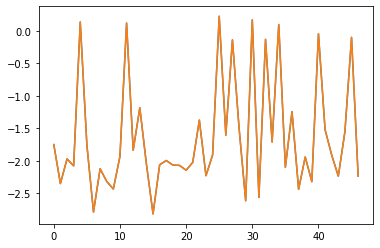

In [1074]:
plt.plot(actual_v_pred_linear['actual'])
plt.plot(actual_v_pred_linear['pred'])